In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import torch
import torch.utils.data as data 

from omegaconf import OmegaConf
from torchvision import transforms
from torch.nn.parallel import DistributedDataParallel as DDP
# 
from contrastive_learning.tests.test_model import load_lin_model, predict_traj_actions
from contrastive_learning.tests.animate_markers import AnimateMarkers
from contrastive_learning.tests.animate_rvec_tvec import AnimateRvecTvec
from contrastive_learning.datasets.dataloaders import get_dataloaders

from contrastive_learning.models.custom_models import LinearInverse
from contrastive_learning.datasets.state_dataset import StateDataset
from contrastive_learning.tests.plotting import plot_rvec_tvec, plot_corners

### Model Loading
Create the distributed group
Load the linear inverse model from the saved path

In [2]:
# Start the multiprocessing to load the saved models properly
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "29504"

torch.distributed.init_process_group(backend='gloo', rank=0, world_size=1)
torch.cuda.set_device(0)

In [11]:
# Set the device and out_dir
device = torch.device('cuda:0')
out_dir = '/home/irmak/Workspace/DAWGE/contrastive_learning/out/2022.07.21/12-51_pli_ue_False_lf_mse_fi_1_pt_rvec_tvec_bs_64_hd_64_lr_0.001_zd_8'
cfg = OmegaConf.load(os.path.join(out_dir, '.hydra/config.yaml'))
model_path = os.path.join(out_dir, 'models/lin_model.pt')

# Load the encoder
lin_model = load_lin_model(cfg, device, model_path)

In [12]:
print(lin_model)

DistributedDataParallel(
  (module): LinearInverse(
    (model): Sequential(
      (0): Linear(in_features=24, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=16, bias=True)
      (3): ReLU()
      (4): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)


In [13]:
print(cfg)

{'agent': {'_target_': 'contrastive_learning.models.agents.pli.PLI', 'loss_fn': 'mse', 'use_encoder': False, 'model': '???', 'optimizer': '???'}, 'optimizer': {'_target_': 'torch.optim.Adam', 'params': '???', 'lr': '???', 'weight_decay': '???'}, 'model': {'_target_': 'contrastive_learning.models.custom_models.LinearInverse', 'input_dim': '???', 'action_dim': '???', 'hidden_dim': '???'}, 'seed': 42, 'device': 'cuda', 'agent_type': 'pli', 'dataset_type': 'state', 'pos_type': 'rvec_tvec', 'train_epochs': 1000, 'save_frequency': 10, 'train_dset_split': 0.8, 'batch_size': 64, 'lr': 0.001, 'weight_decay': 0, 'z_dim': 8, 'pos_dim': 6, 'hidden_dim': 64, 'action_dim': 2, 'distributed': True, 'num_workers': 4, 'world_size': 1, 'num_gpus': 4, 'fps': 15, 'frame_interval': 1, 'video_type': 'color', 'experiment': '${agent_type}_ue_${agent.use_encoder}_lf_${agent.loss_fn}_fi_${frame_interval}_pt_${pos_type}_bs_${batch_size}_hd_${hidden_dim}_lr_${lr}_zd_${z_dim}', 'data_dir': '/home/irmak/Workspace/DA

### Action Animation
1. Dump every predicted action for given data directory
2. Save the predicted and current action in a video

In [14]:
demo_name = 'box_marker_35'
exp_name = out_dir.split('/')[-1]
data_dir = '/home/irmak/Workspace/DAWGE/src/dawge_planner/data/{}'.format(demo_name)
dump_dir = '/home/irmak/Workspace/DAWGE/contrastive_learning/tests/animations'
dump_file = '{}_{}.mp4'.format(demo_name, exp_name)

fps = 15

In [15]:
# Get the dataset
dataset = StateDataset(cfg, single_dir=True, single_dir_root=data_dir)
predicted_actions = np.zeros((len(dataset), 2))
test_loader = data.DataLoader(dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=4)

for i, batch in enumerate(test_loader):
    curr_pos, next_pos, action = [b.to(device) for b in batch]
    pred_action = lin_model(curr_pos, next_pos)

    print('Actual Action \t Predicted Action')
    for j in range(len(action)):
        print('{}, \t{}'.format(np.around(dataset.denormalize_action(action[j][0].cpu().detach().numpy()), 2),
                                          dataset.denormalize_action(pred_action[j][0].cpu().detach().numpy())))
        predicted_actions[i*cfg.batch_size+j,:] = dataset.denormalize_action(pred_action[j][0].cpu().detach().numpy())

with open(os.path.join(data_dir, 'predicted_actions.npy'), 'wb') as f:
    np.save(f, predicted_actions)

Actual Action 	 Predicted Action
[0.15 0.3 ], 	[0.2135221 0.5540884]
[ 0.  -0.3], 	[0.12950244 0.21800974]
[ 0.  -0.3], 	[0.11379987 0.15519949]
[0.15 0.3 ], 	[0.09643731 0.08574922]
[0.15 0.3 ], 	[0.09680391 0.08721564]
[0.15 0.3 ], 	[0.1227905  0.19116197]
[0.15 0.3 ], 	[0.15734357 0.32937428]
[0.15 0.3 ], 	[0.10346277 0.11385105]
[0.15 0.3 ], 	[0.10327446 0.11309782]
[0.15 0.3 ], 	[0.09985648 0.09942592]
[0.15 0.3 ], 	[0.16899278 0.37597112]
[ 0.  -0.3], 	[0.0913873  0.06554919]
[0.15 0.3 ], 	[0.16511034 0.36044134]
[0.15 0.3 ], 	[0.11271109 0.15084433]
[0.15 0.3 ], 	[0.11825907 0.17303625]
[0.15 0.3 ], 	[0.12571174 0.20284696]
[0.15 0.3 ], 	[0.12578668 0.20314673]
[ 0.  -0.3], 	[0.12197899 0.18791593]
[0.15 0.3 ], 	[0.17618697 0.40474786]
[0.15 0.3 ], 	[0.12137037 0.18548148]
[ 0.  -0.3], 	[0.10362837 0.11451345]
[0.15 0.3 ], 	[0.11152381 0.14609525]
[0.15 0.3 ], 	[0.13885773 0.25543092]
[ 0.  -0.3], 	[0.13247433 0.22989729]
[0.15 0.3 ], 	[0.12937455 0.21749819]
[0.15 0.3 ], 	[0.13

Starting Animation


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:13<00:00,  5.34it/s]


Animation saved to: /home/irmak/Workspace/DAWGE/contrastive_learning/tests/animations/box_marker_35_12-51_pli_ue_False_lf_mse_fi_1_pt_rvec_tvec_bs_64_hd_64_lr_0.001_zd_8.mp4


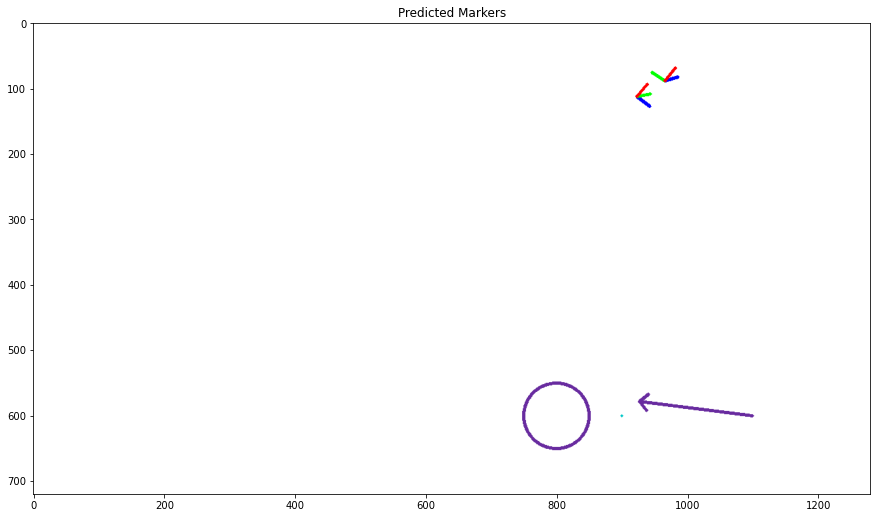

In [16]:

if cfg.pos_type == 'corners':
    AnimateMarkers(
        data_dir = data_dir, 
        dump_dir = dump_dir, 
        dump_file = dump_file, 
        fps = fps,
        mult_traj = False,
        show_predicted_action = True 
    ) # Saves them in the given dump_file
elif cfg.pos_type == 'rvec_tvec':
    AnimateRvecTvec(
        data_dir = data_dir, 
        dump_dir = dump_dir, 
        dump_file = dump_file,
        fps = fps,
        show_predicted_action=True
    )

### Action Prediction Image
Predict the action for each frame in the test dataset and dump them in a grid image

In [17]:
cfg.batch_size = 32
train_loader, test_loader, dataset = get_dataloaders(cfg)

In [18]:
len(test_loader.dataset)
batch = next(iter(test_loader))
curr_pos, next_pos, action = [b.to(device) for b in batch]
pred_action = lin_model(curr_pos, next_pos)

curr_pos.shape

torch.Size([32, 12])

In [19]:
print(curr_pos[0])

tensor([0.6093, 0.8317, 0.2959, 0.2139, 0.0749, 0.2621, 0.7246, 0.6565, 0.4072,
        0.1871, 0.0938, 0.2478], device='cuda:0')


(4, 8)


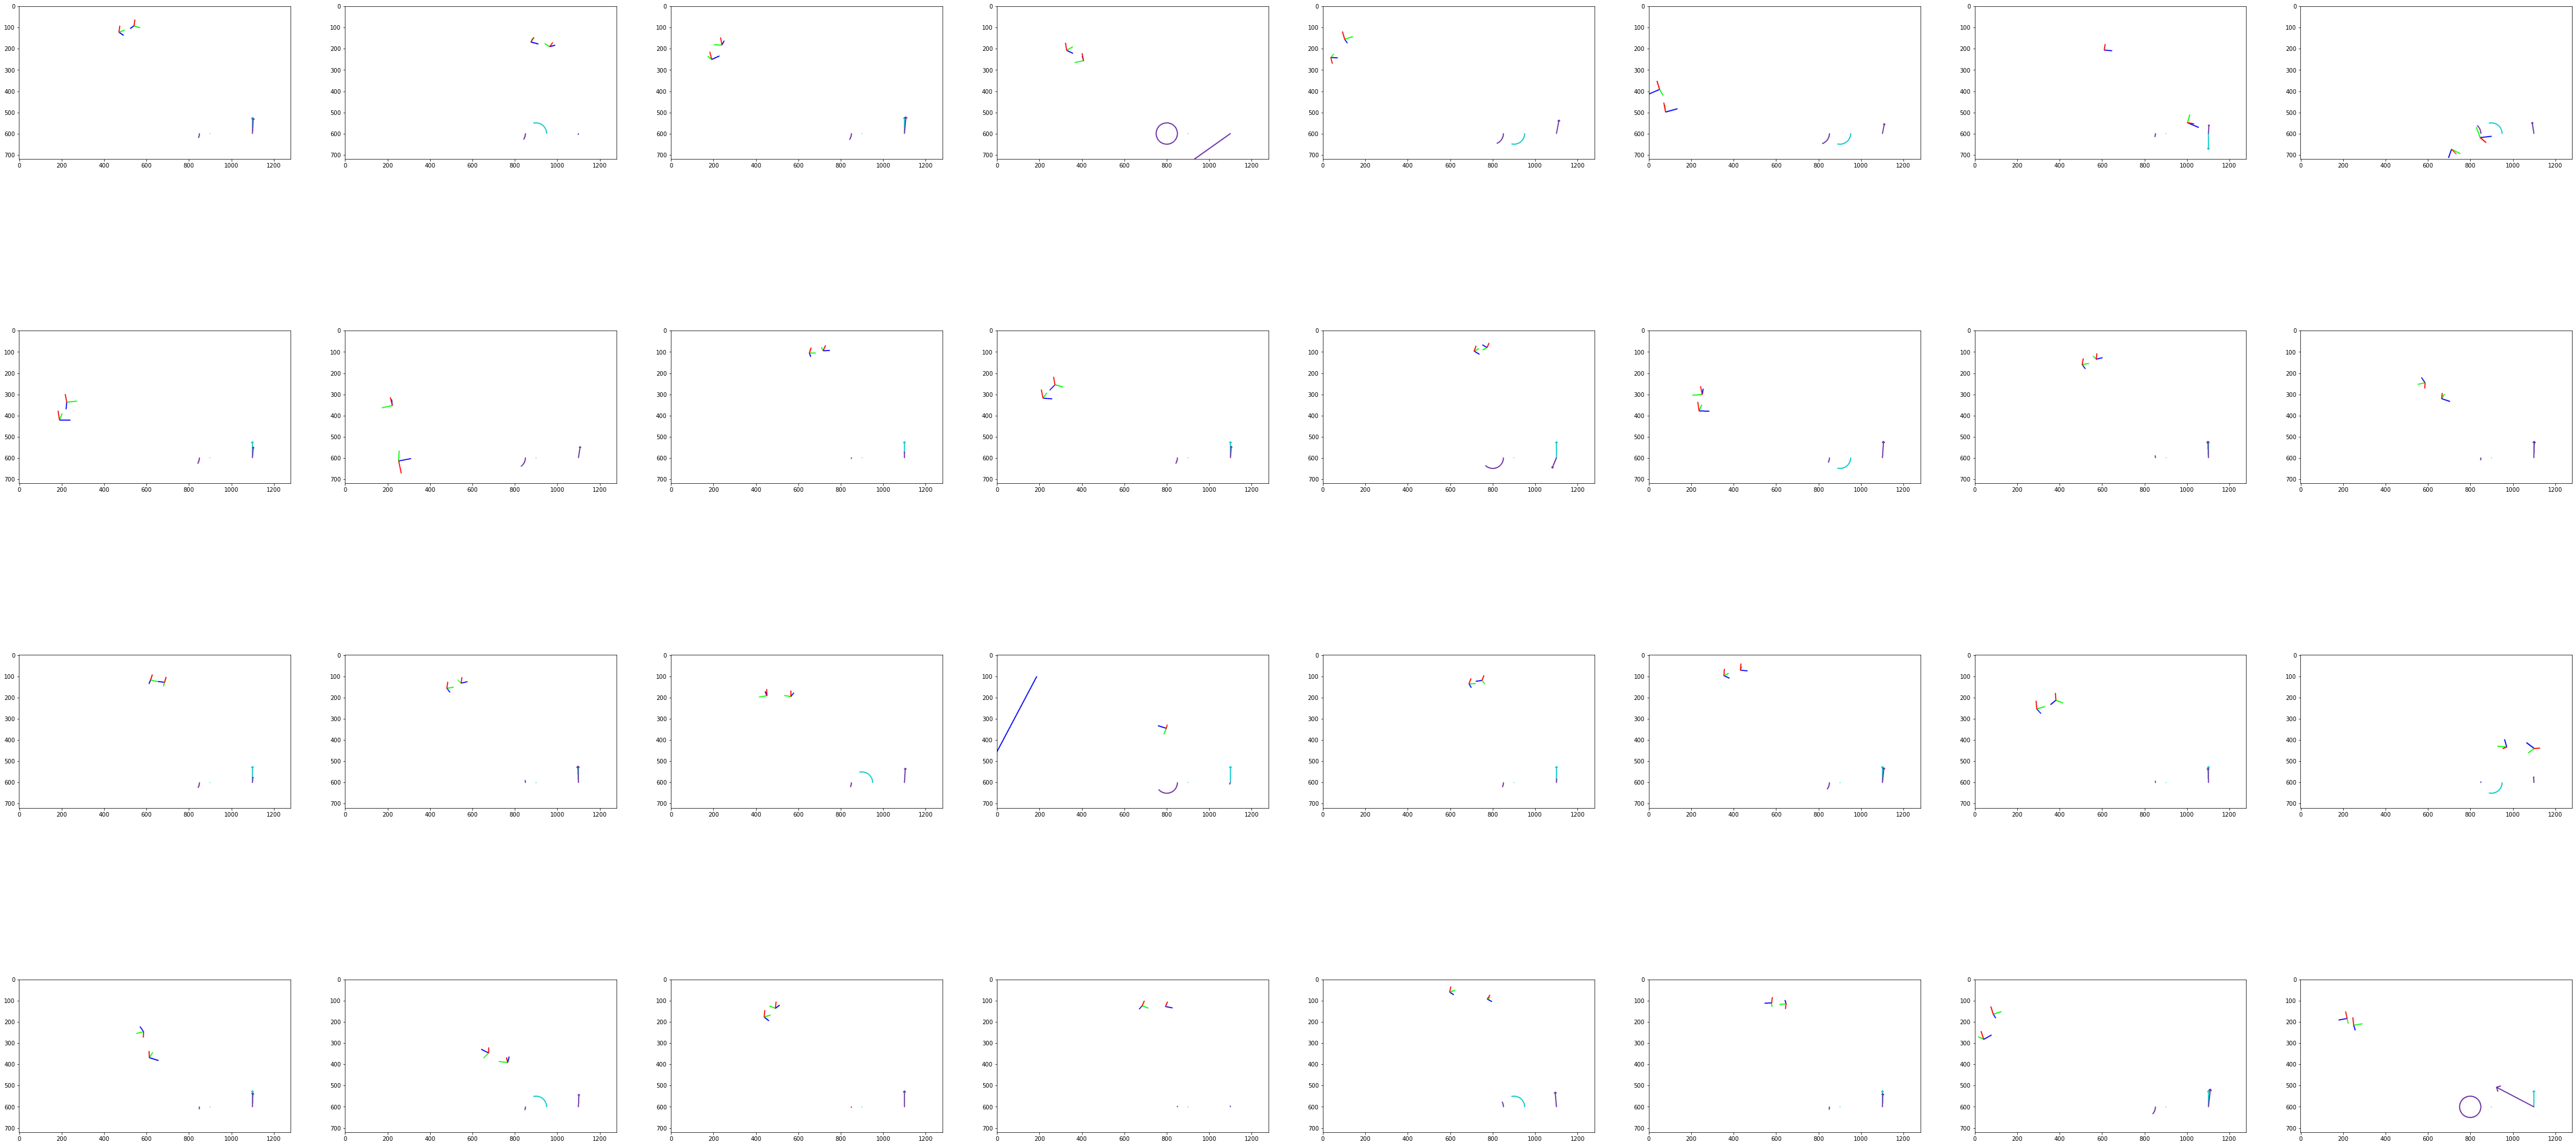

In [21]:
nrows = 4
ncols = int(cfg.batch_size / nrows)
fig, axs = plt.subplots(figsize=(ncols*10,nrows*10), nrows=nrows, ncols=ncols) # Draw the predicted action
print(axs.shape)

for i in range(cfg.batch_size):
    axs_row = int(i / nrows)
    axs_col = int(i % nrows)
    
    action_np = dataset.denormalize_action(action[i].cpu().detach().numpy())
    pred_action_np = dataset.denormalize_action(pred_action[i].cpu().detach().numpy())
    
    if cfg.pos_type == 'corners':
        curr_pos_np = dataset.denormalize_corner(curr_pos[i].cpu().detach().numpy())
        plot_corners(
            ax=axs[axs_col, axs_row],
            curr_pos=curr_pos_np,
            use_img=False,
            img=None,
            plot_action=True,
            actions=(action_np, pred_action_np))
    elif cfg.pos_type == 'rvec_tvec':
        curr_pos_np = dataset.denormalize_pos_rvec_tvec(curr_pos[i].cpu().detach().numpy())
        plot_rvec_tvec(
            ax=axs[axs_col, axs_row],
            curr_pos=curr_pos_np,
            use_img=False,
            img=None,
            plot_action=True,
            actions=(action_np, pred_action_np))
        
plt.savefig(os.path.join(out_dir, 'pil_action_test.jpg'))
    